## Generating the graphs

Here, we generate 1000 random walks on random graphs with 20 nodes and edge density 0.1. We keep the same start and goal node for each graph and each random walk. We then take each step in the random walk and extract the state (the index of the current node we are at), the action (the index of the next node chosen in the graph) and the returns-to-go (the negative sum of the number of steps left in our path). 

In [96]:
import networkx as nx
import random

# Set the random seed
random.seed(42)

def generate_random_graph(num_nodes, edge_prob):
    """
    Generate a random directed graph with a specified number of nodes and edge probability.
    """
    graph = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob, directed=True)
    return graph

def random_walk_with_returns(graph, start_node, goal_node, max_steps=10):
    """
    Perform a random walk on the graph starting from a specified node, calculating returns-to-go at each step.
    """
    current_node = start_node
    walk_data = []
    steps = 0

    while current_node != goal_node and steps < max_steps:
        neighbors = list(graph.neighbors(current_node))
        next_node = random.choice(neighbors) if neighbors else current_node
        if nx.has_path(graph, source=next_node, target=goal_node):
            path_to_goal = nx.shortest_path_length(graph, source=next_node, target=goal_node)
            return_to_go = -path_to_goal
        else:
            return_to_go = -max_steps
        walk_data.append((current_node, next_node, return_to_go))
        current_node = next_node
        steps += 1

    return walk_data

def create_training_sequences(num_graphs, num_nodes, edge_prob, start_node, goal_node, max_steps=10):
    """
    Create training sequences from multiple random graph walks.
    """
    training_sequences = []

    for _ in range(num_graphs):
        graph = generate_random_graph(num_nodes, edge_prob)
        walk_data = random_walk_with_returns(graph, start_node, goal_node, max_steps)

        # Construct training sequences by progressively building up the length of the walk
        for i in range(1, len(walk_data) + 1):
            sequence = walk_data[:i]  # Get the first 'i' elements of the walk
            training_sequences.append(sequence)

    return training_sequences

# Generate training sequences
num_graphs = 1000  # Number of random graphs
num_nodes = 20  # Nodes in each graph
edge_prob = 0.1  # Edge probability
start_node, goal_node = 0, 5  # Example start and goal nodes
max_steps = 10  # Maximum steps in each random walk

training_sequences = create_training_sequences(num_graphs, num_nodes, edge_prob, start_node, goal_node, max_steps)

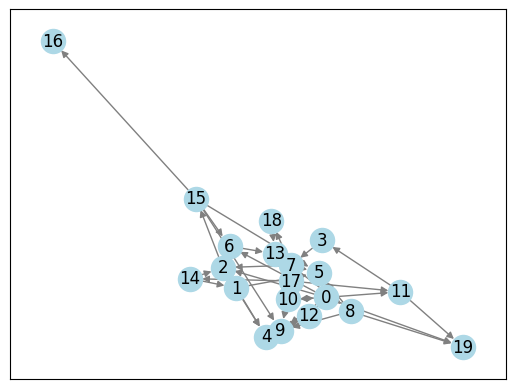

In [100]:
# Load fixed graph from pickle file
import pickle

# Generate training sequences
num_graphs = 1000  # Number of random graphs
num_nodes = 20  # Nodes in each graph
edge_prob = 0.1  # Edge probability
start_node, goal_node = 0, 5  # Example start and goal nodes
max_steps = 10  # Maximum steps in each random walk

def generate_connected_graph(num_nodes, edge_prob):
    while True:
        graph = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob, directed=True)
        if nx.is_weakly_connected(graph):
            return graph

# Use this function instead of generate_random_graph
fixed_graph = generate_connected_graph(num_nodes, edge_prob)

# Save the fixed graph to a pickle file
with open('fixed_graph.pkl', 'wb') as f:
    pickle.dump(fixed_graph, f)

# Load the fixed graph from the pickle file
with open('fixed_graph.pkl', 'rb') as f:
    fixed_graph = pickle.load(f)

# Draw the fixed graph with networkx
nx.draw_networkx(fixed_graph, pos=nx.spring_layout(fixed_graph), node_color='lightblue', edge_color='grey')

In [101]:
def random_walk_with_returns(graph, start_node, goal_node, max_steps=10):
    current_node = start_node
    walk_data = []
    steps = 0

    while steps < max_steps:
        neighbors = list(graph.neighbors(current_node))
        if neighbors:
            next_node = random.choice(neighbors)
            if nx.has_path(graph, source=next_node, target=goal_node):
                path_to_goal = nx.shortest_path_length(graph, source=next_node, target=goal_node)
                return_to_go = -path_to_goal - 1
            else:
                return_to_go = -max_steps  # Unreachable path
        else:
            next_node = current_node  # No neighbors
            return_to_go = -max_steps  # Unreachable path

        walk_data.append((return_to_go, current_node, next_node))
        current_node = next_node
        steps += 1

        if current_node == goal_node:
            break

    return walk_data

In [102]:
def create_training_sequences(graph, num_walks, max_steps=10):
    training_sequences = []
    for _ in range(num_walks):
        # Randomly choose a start and goal node
        start_node = random.choice(list(graph.nodes))
        # Make sure goal node is different from start node
        goal_node = random.choice(list(graph.nodes))
        while goal_node == start_node:
            goal_node = random.choice(list(graph.nodes))
        walk_data = random_walk_with_returns(graph, start_node, goal_node, max_steps)
        for i in range(1, len(walk_data) + 1):
            # Prepend each sequence with the target node
            sum_return = sum([step[0] for step in walk_data[:i]])
            sequence = [(sum_return, goal_node, start_node)] + walk_data[:i]
            training_sequences.append(sequence)
    return training_sequences

# Generate training sequences using the fixed graph
training_sequences = create_training_sequences(fixed_graph, num_graphs, max_steps)

In [81]:
len(training_sequences)

8771

Examining one of these training sequences:

In [90]:
# Get a random training sequence
random.choice(training_sequences)

[(-39, 15, 9), (-5, 9, 17), (-4, 17, 6), (-10, 6, 4), (-10, 4, 4), (-10, 4, 4)]

In [83]:
training_sequences[1005]

[(-50, 14, 12),
 (-10, 12, 12),
 (-10, 12, 12),
 (-10, 12, 12),
 (-10, 12, 12),
 (-10, 12, 12)]

In [84]:
training_sequences[1006]

[(-60, 14, 12),
 (-10, 12, 12),
 (-10, 12, 12),
 (-10, 12, 12),
 (-10, 12, 12),
 (-10, 12, 12),
 (-10, 12, 12)]

Interpreting this, we see that the agent started at node 0, and then chose to go to node 1. (Finish this explanation.)

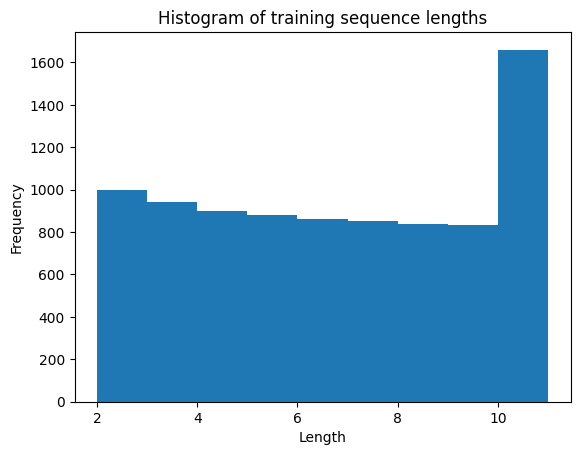

In [91]:
# Plot a histogram of the lengths of the training sequences
import matplotlib.pyplot as plt

sequence_lengths = [len(sequence) for sequence in training_sequences]
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 1))
plt.title('Histogram of training sequence lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, action_dim, embed_dim, num_layers, num_heads, max_steps):
        super(DecisionTransformer, self).__init__()
        self.embed_dim = embed_dim
        self.embed_s = nn.Embedding(state_dim+1, embed_dim)
        self.embed_a = nn.Embedding(action_dim+1, embed_dim)
        self.embed_R = nn.Linear(1, embed_dim)  
        self.embed_t = nn.Embedding(max_steps+1, embed_dim)

        self.encoder_layers = nn.TransformerEncoderLayer(d_model=3*embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)

        self.pred_a = nn.Linear(3*embed_dim, action_dim+1)

    def forward(self, R, s, a, t):
        R_emb = self.embed_R(R.unsqueeze(-1))
        s_emb = self.embed_s(s)
        a_emb = self.embed_a(a)
        t_emb = self.embed_t(t)

        # Stack embeddings and add timesteps embeddings to each
        stacked_embeds = torch.stack((R_emb, s_emb, a_emb), dim=2)  # New shape: [batch, seq_len, 3, embed_dim]
        t_emb = t_emb.unsqueeze(2)  # New shape: [batch, seq_len, 1, embed_dim]
        
        # Repeat t_emb to match the shape of stacked_embeds and add
        t_emb = t_emb.expand(-1, -1, 3, -1)
        input_embeds = stacked_embeds + t_emb  # Broadcasting addition

        # Reshape for transformer and permute to match expected shape (seq_len, batch, dim)
        input_embeds = input_embeds.reshape(-1, stacked_embeds.shape[1], 3 * self.embed_dim).permute(1, 0, 2)

        # Pass through transformer encoder
        transformer_output = self.transformer_encoder(input_embeds)
        action_logits = self.pred_a(transformer_output)[-1]

        return action_logits

class DecisionTransformerDataset(Dataset):
    def __init__(self, sequences, max_length):
        """
        sequences: A list of sequences where each sequence is a list of (state, action, return-to-go) tuples.
        max_length: Maximum length of sequences after padding.
        """
        self.sequences = sequences
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        R, s, a = zip(*sequence)

        # Pad the sequences if they are shorter than max_length
        seq_length = len(R)
        padding_length = self.max_length - seq_length + 1 # Plus 1 because we add the goal to the start

        # Pad R, s, and a with zeros (assuming 20 is a valid padding index)
        R_padded = torch.tensor(R + (20,) * padding_length, dtype=torch.float32)
        s_padded = torch.tensor(s + (20,) * padding_length, dtype=torch.long)
        a_padded = torch.tensor(a + (20,) * padding_length, dtype=torch.long)
        
        # Create a tensor for timesteps
        t = torch.arange(self.max_length+1, dtype=torch.long)

        return R_padded, s_padded, a_padded, t

max_sequence_length = 10  # Assuming the maximum length of sequences is 10
dataset = DecisionTransformerDataset(training_sequences, max_sequence_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model parameters
state_dim = 20  # number of nodes (plus 1 for padding index)
action_dim = 20  # same as state_dim (plus 1 for padding index)
embed_dim = 128  # embedding dimension
num_layers = 1  # number of transformer encoder layers
num_heads = 4   # number of heads in multiheadattention models
max_steps = 10  # maximum number of steps in a sequence (plus 1 for padding index)

# Instantiate the model
model = DecisionTransformer(state_dim, action_dim, embed_dim, num_layers, num_heads, max_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for R, s, a, t in dataloader:

    # Add checks for specific ranges if necessary
    if s.max().item() > state_dim or a.max().item() > action_dim:
        raise ValueError("State or action index out of range")

# Training loop
num_epochs = 10  # adjust as necessary

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for R, s, a, t in dataloader:
        
        # Forward pass: predict next action based on all but the last timestep
        # Print the inputs to the model
        print(f"R: {R}")
        print(f"s: {s}")
        print(f"a: {a}")
        print(f"t: {t}")
        action_logits = model(R[:, :-1], s[:, :-1], a[:, :-1], t[:, :-1])
        #print(f"action_logits: {action_logits}")
        print(f"Chosen action: {torch.argmax(action_logits, dim=1)}")
        print(f"Target action: {a[:, -1]}")

        # Compute loss using the next action (last action in each sequence)
        loss = criterion(action_logits, a[:, -1])

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.2f}")

R: tensor([[ -4.,  -4.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [-49.,  -6.,  -7.,  -6., -10., -10., -10.,  20.,  20.,  20.,  20.],
        [-59.,  -8.,  -7.,  -6.,  -8., -10., -10., -10.,  20.,  20.,  20.],
        [ -2.,  -2.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [-27.,  -2.,  -4.,  -3.,  -5.,  -4.,  -5.,  -4.,  20.,  20.,  20.],
        [ -5.,  -5.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [-80., -10., -10., -10., -10., -10., -10., -10., -10.,  20.,  20.],
        [-80., -10., -10., -10., -10., -10., -10., -10., -10.,  20.,  20.],
        [-17.,  -4.,  -7.,  -6.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ -5.,  -5.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ -3.,  -3.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [-22.,  -5.,  -6.,  -6.,  -5.,  20.,  20.,  20.,  20.,  20.,  20.],
        [ -9.,  -4.,  -3.,  -2.,  20.,  20.,  20.,  20.,  20.,  20.,  20.],
        [

KeyboardInterrupt: 

## Generation

In [134]:
# def generate_path(model, graph, start_node, goal_node, max_steps=10):
#     # Calculate initial return-to-go (RtG) as the shortest path length (or a large number)
#     if nx.has_path(graph, current_node, goal_node):
#         initial_rtg = -nx.shortest_path_length(graph, current_node, goal_node)
#     else:
#         initial_rtg = -max_steps  # Large penalty if no path exists

#     # Initialize sequence
#     sequence = [(initial_rtg, goal_node, start_node)]
#     current_node = start_node

#     for step in range(max_steps):
#         # Convert current sequence to tensors and add batch dimension
#         R, s, a = zip(*sequence)
#         R_tensor = torch.tensor([R], dtype=torch.float32)
#         s_tensor = torch.tensor([s], dtype=torch.long)
#         a_tensor = torch.tensor([a], dtype=torch.long)
#         t_tensor = torch.arange(len(R)).unsqueeze(0)

#         # Predict next action
#         with torch.no_grad():
#             action_logits = model(R_tensor, s_tensor, a_tensor, t_tensor)
#             # Softmax the action_logits
#             action_probs = F.softmax(action_logits, dim=-1)
#             # Print the action logits nicely
#             print(f"Step {step+1} action probs: {action_probs.squeeze().numpy()}")
#             next_node = torch.argmax(action_probs, dim=-1).item()

#         print(f"Step {step+1}: {current_node} -> {next_node}")

#         # Update sequence
#         if nx.has_path(graph, source=next_node, target=goal_node):
#             path_to_goal = nx.shortest_path_length(graph, source=next_node, target=goal_node)
#             next_rtg = -path_to_goal - 1
#         else:
#             next_rtg = -max_steps  # Unreachable path

#         sequence.append((next_rtg, current_node, next_node))
#         current_node = next_node

#         if current_node == goal_node:
#             break

#     # Get the generated and shortest paths
#     generated_path = [step[2] for step in sequence[1:]]
#     shortest_path = nx.shortest_path(graph, source=start_node, target=goal_node) if nx.has_path(graph, source=start_node, target=goal_node) else "No path available"

#     return generated_path, shortest_path

import torch
import torch.nn.functional as F
import networkx as nx

def generate_path(model, graph, start_node, goal_node, max_steps=10):
    # Calculate initial return-to-go (RtG) as the shortest path length (or a large number)
    if nx.has_path(graph, start_node, goal_node):
        initial_rtg = -nx.shortest_path_length(graph, start_node, goal_node)
    else:
        initial_rtg = -max_steps  # Large penalty if no path exists

    # Initialize sequence with start node and high initial RtG
    sequence = [(initial_rtg, start_node, start_node)]
    current_node = start_node

    for step in range(max_steps):
        # Convert current sequence to tensors and add batch dimension
        R, s, a = zip(*sequence)
        R_tensor = torch.tensor([R], dtype=torch.float32)
        s_tensor = torch.tensor([s], dtype=torch.long)
        a_tensor = torch.tensor([a], dtype=torch.long)
        t_tensor = torch.arange(len(R)).unsqueeze(0)

        print(f"Step {step+1} RtG: {R_tensor.squeeze().numpy()}")
        print(f"Step {step+1} state: {s_tensor.squeeze().numpy()}")
        print(f"Step {step+1} action: {a_tensor.squeeze().numpy()}")
        print(f"Step {step+1} timesteps: {t_tensor.squeeze().numpy()}")

        # Predict next action
        with torch.no_grad():
            action_logits = model(R_tensor, s_tensor, a_tensor, t_tensor)
            print(f"Step {step+1} action logits: {action_logits}")
            next_node = torch.argmax(action_logits, dim=-1).item()

        # Update current node and sequence with next action
        if next_node in graph.neighbors(current_node):
            current_node = next_node
            if nx.has_path(graph, source=current_node, target=goal_node):
                next_rtg = -nx.shortest_path_length(graph, current_node, goal_node) - 1
            else:
                next_rtg = -max_steps
        else:
            next_rtg = -max_steps  # Stay at current node if no valid move

        sequence.append((next_rtg, current_node, next_node))

        # Break the loop if goal node is reached
        if current_node == goal_node:
            break

    # Extract the generated path
    generated_path = [a for _, _, a in sequence[1:]]

    # Compute the shortest path for comparison
    shortest_path = nx.shortest_path(graph, start_node, goal_node) if nx.has_path(graph, start_node, goal_node) else "No path available"

    return generated_path, shortest_path

In [135]:
# Assume 'model' is your trained Decision Transformer model
# Assume 'graph' is the graph you want to use (e.g., generated by NetworkX)
# Choose your start and goal nodes
start_node = 0
goal_node = 5

# Call the function
generated_path, shortest_path = generate_path(model, fixed_graph, start_node, goal_node, max_steps=10)

# Print the results
print("Generated Path by Model:", generated_path)
print("Shortest Path (NetworkX):", shortest_path)

Step 1 RtG: -3.0
Step 1 state: 0
Step 1 action: 0
Step 1 timesteps: 0
Step 1 action logits: tensor([[-1.5806, -3.2147, -2.2271, -5.1511, -5.5399, -4.9102, -2.7526, -0.4058,
         -7.4956, -1.7320, -1.5351, -1.4739, -0.5351, -2.9573, -5.0761, -3.8288,
         -1.8937, -5.9330, -4.2592, -0.2902,  8.2642]])
Step 2 RtG: [ -3. -10.]
Step 2 state: [0 0]
Step 2 action: [ 0 20]
Step 2 timesteps: [0 1]
Step 2 action logits: tensor([[-2.4505, -5.4756, -2.3319, -2.9221, -3.1584, -4.5008, -6.1352, -4.4158,
         -4.5732, -2.8016, -4.0174, -4.9335, -2.6657, -2.7355, -4.9034, -2.9176,
          4.8095, -4.3752, -6.0702,  5.3077,  5.3521]])
Step 3 RtG: [ -3. -10. -10.]
Step 3 state: [0 0 0]
Step 3 action: [ 0 20 20]
Step 3 timesteps: [0 1 2]
Step 3 action logits: tensor([[-2.3406, -6.1058, -2.9551, -5.1531, -5.2780, -5.8961, -6.6316, -5.3839,
         -6.4554, -3.8367, -4.9906, -5.3313, -3.0690, -3.6649, -6.0506, -3.4281,
          5.4362, -5.8620, -6.3165,  5.1225,  8.0085]])
Step 4 RtG: [ -3